In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn import svm

# grAdapt
import grAdapt
from grAdapt.models import Sequential
from grAdapt.space.datatype import Integer, Float, Categorical

## 1. Introduction
This is a brief tutorial on how to tune hyperparameters of the support vector machine (SVM) with **grAdapt**. To show that grAdapt works with multiple input dimensions, three hyperparameters of the SVM will be tuned where each hyperparameter can have a different type than the other.

### 1.1 Data Set
For the data set, we will use the **NIST data set** as it is small enough to train a classifier fast on it. Though the nature of the developed package is to optimize of float variables, we will take a look at integer and categorical optimization.

In [2]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

print(data.shape)

# Split data into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    data, digits.target, test_size=0.8, shuffle=False)

(1797, 64)


## 2. Define Blackbox

The intuition behind defining a blackbox function is to fit the classifier to the training set and then returning the validation accuracy. The validation accuracy is to be maximized and the input variables of the blackbox function are the hyperparameters. The hyperparameters are set when creating a classifier instance.

In [4]:
def svm_opt(C, gamma, kernel):
    # create SVM instance
    clf = svm.SVC(C=C, gamma=gamma, kernel=kernel)
    
    # fit/train
    clf.fit(X_train, y_train)
    
    # return validation accuracy
    return clf.score(X_val, y_val)

## 3. Hyperparameter Optimization with grAdapt

In this section, we are creating a **grAdapt Sequential** model. For brevity, settings of the Sequential model are not demonstrated. We will also take a look how to define search spaces by using **grAdapt Datatypes**.


Support Vector Machine takes three hyperparameters which are *C*, *gamma* and the *kernel* function. Both *C* and *gamma* are float variables. The last hyperparameter is a categorical variable which is a list of strings.

In [5]:
# create base model
model = Sequential()

# create search space
c_var = Float(low=1e-3, high=100, prior='log-uniform')
gamma_var = Float(low=1e-3, high=1e3, prior='log-uniform')
#c_var = Float(low=1e-3, high=100)
#gamma_var = Float(low=1e-3, high=1e3)
kernel_var = Categorical(['linear', 'poly', 'sigmoid', 'rbf'])
bounds = [c_var, gamma_var, kernel_var]

In [6]:
res_svm = model.maximize_args(svm_opt, bounds, 1000, show_progressbar=True)

  0%|▏                                                                                | 3/1000 [00:00<00:35, 27.70it/s]

Sampling 273 random points.
Random function evaluations. This might take a while.


 28%|█████████████████████▋                                                         | 275/1000 [00:00<00:43, 16.66it/s]

Finding optimum...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.59it/s]


In [7]:
y_svm = res_svm['y']
x_svm = res_svm['x']

In [8]:
x_svm_sol = res_svm['x_sol']
y_svm_sol = res_svm['y_sol']
print(x_svm_sol)
print(y_svm_sol)

[100.01151370337128 0.0010000138156198081 'rbf']
0.9012517385257302


### 3.1 Training Plot

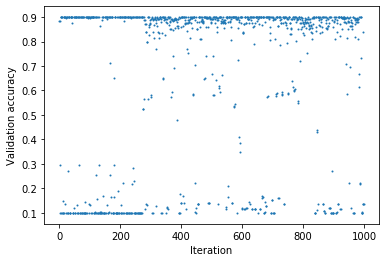

In [39]:
plt.scatter(np.arange(y_svm.shape[0]), y_svm, s=1)
#plt.title('Training plot')
plt.xlabel('Iteration')
plt.ylabel('Validation accuracy')
plt.savefig("plots/trainingloss.pdf", bbox_inches="tight")
plt.show()

### 3.2 Hyperparameter Plot

#### 3.2.1 C Value

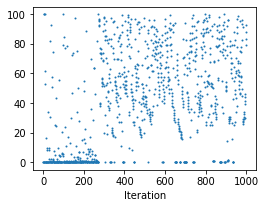

In [40]:
plt.figure(figsize=(4,3))
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,0], s=1)
#plt.title('Training plot')
plt.xlabel('Iteration')
#plt.ylabel('SVM C')
plt.savefig("plots/training_c.pdf", bbox_inches="tight")
plt.show()

#### 3.2.2 gamma

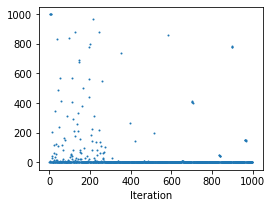

In [41]:
plt.figure(figsize=(4,3))
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,1], s=1)
#plt.scatter(np.arange(x_svm.shape[0]), np.ones(x_svm.shape[0])*x_svm_sol[1])
#plt.title('Training plot')
plt.xlabel('Iteration')
#plt.ylabel('SVM gamma')
plt.savefig("plots/training_gamma.pdf", bbox_inches="tight")
plt.show()

#### 3.2.3 kernel

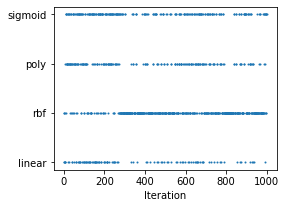

In [38]:
plt.figure(figsize=(4,3))
plt.scatter(np.arange(x_svm.shape[0]), x_svm[:,2], s=1)
#plt.title('Training plot')
plt.xlabel('Iteration')
#plt.ylabel('SVM kernel')
plt.savefig("plots/training_kernel.pdf", bbox_inches="tight")
plt.show()

### 3.3 Hyperparameter Space Plot

<IPython.core.display.Javascript object>


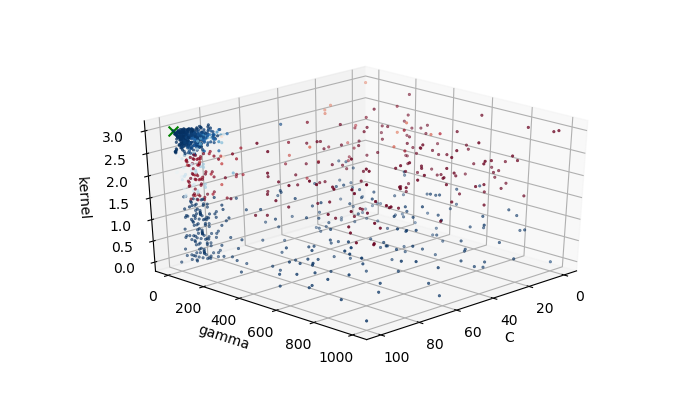

In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(7,4))
ax = plt.axes(projection='3d')
x_svm_plot = res_svm['x_internal']
x_svm_sol_plot = res_svm['x_sol_internal']
ax.scatter(x_svm_plot[:,0], x_svm_plot[:,1], x_svm_plot[:,2], c=y_svm, cmap='RdBu', linewidth=0.5, s=3)
ax.scatter(x_svm_sol_plot[0], x_svm_sol_plot[1], x_svm_sol_plot[2], marker='x', c='g', s=50)
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('kernel');
plt.savefig("plots/3dplot.pdf", bbox_inches="tight", pad_inches = 0)
plt.show()

## 4. Results

Optimizing three hyperparameters at once does not seem to be a problem for grAdapt. Even if the hyperparameters are of different datatypes (float+categorical).

It can be obtained that high *C* and low *gamma* values led to good performances. grAdapt often escapes but also stays local when good solutions were found. For the categorical variable, RBF seems to be the first choice which is also usually set as a stock setting.

Because each variable can influence each other, it is astonishing to see that grAdapt handles this well and has found good settings for each parameter.